# XGB Regressor

Note: feature engineering logic adapted from the challenge notebook [https://www.kaggle.com/code/nikitamanaenkov/stock-price-prediction-sample/notebook](https://www.kaggle.com/code/nikitamanaenkov/stock-price-prediction-sample/notebook)

In [38]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from sklearn.multioutput import RegressorChain
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from statsmodels.tsa.api import SimpleExpSmoothing
from xgboost import XGBRegressor

LOCAL = True
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
print(f"rootpath: {rootpath}")
# module_path = os.path.abspath(os.path.join(rootpath, 'src'))
# sys.path.insert(0, module_path)
from data import download_stock_price_prediction_challenge_data

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


In [2]:
if LOCAL:
    dirfpath = download_stock_price_prediction_challenge_data(rootpath)
    test_path = os.path.join(dirfpath, "test")
    train_stocks_path = os.path.join(dirfpath, "train", "stocks")
    train_indices_path = os.path.join(dirfpath, "train", "indices")
    
else:
    test_path = "/kaggle/input/stock-price-prediction-challenge/test"
    indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices"

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/stock-price-prediction-challenge.zip
Raw data already unzipped


## Data Prep and Feature Engineering

In [3]:
def get_ticker_df(ticker_name):
    if 'test' in ticker_name:
        i = int(ticker_name.split('_')[1])
        assert i>=1 and i<=5
        fpath = os.path.join(test_path, f"test_{i}.csv")
    else:
        fpath = os.path.join(train_stocks_path, f"{ticker_name}.csv")
    if not os.path.exists(fpath):
        raise Exception(f"File {fpath} does not exist")
    df = pd.read_csv(fpath)
    return df

def add_indice_features(df_ticker, target):
    # Read index data and merge in a single dataframe
    indices = {
        "dj": "Dow_Jones.csv",
        "nasdaq": "NASDAQ.csv",
        "SP500": "SP500.csv"
    }
    # merged_df = test_dfs[0][['Date', f'return_1', f'close_1', f'volume_1']]
    merged_index_df = df_ticker 
    for i, (key, filename) in enumerate(indices.items()):
        index_df = pd.read_csv(os.path.join(train_indices_path, filename))
        index_df = index_df.rename(columns={f"{target}": f"{target}_{key}"})
        merged_index_df = pd.merge(merged_index_df, index_df[['Date', f'{target}_{key}']], on='Date', how='left')
    # print(f'shape merged_index_df: {merged_index_df.shape}')
    merged_index_df.head()
    return merged_index_df

def prepare_features(df, target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0], lags=1, out_len=500):
    extended_len = out_len + max(ma_windows)-1
    df = df[-extended_len:].copy()
    # print(f'shape of extended df: {df.shape}')
    
    # df['Adjusted_Yesterday'] = df['Adjusted'].shift(1)
    # df['rel_return'] = (df['Adjusted'] - df['Adjusted_Yesterday']) / df['Adjusted_Yesterday']
    df['Volatility'] = (df['High'] - df['Low']) / ((df['High'] + df['Low']) / 2)
    df['Dollar_Vol'] = df['Volume'] * ((df['Open'] + df['Close']) / 2)

    for lag in range(1, lags + 1):
        df[f'{target}_lag{lag}'] = df[target].shift(lag)

    for window in ma_windows:
        df[f'{target}_MA{window}'] = df[target].rolling(window=window).mean()

    # exponential smoothing
    for alpha in ewm_alpha:
        if alpha == 0:
            fit = SimpleExpSmoothing(df[target], initialization_method="estimated").fit()
            print(f'Optimal alpha for exponential smoothing: {fit.params["smoothing_level"]}')
            df[f'{target}_EWMopt'] = fit.fittedvalues
        else:
            df[f'{target}_EWM{alpha}'.replace('.', '')] = df['Returns'].ewm(alpha=alpha).mean()
    

    df['Close_ROC10'] = df['Close'].pct_change(periods=10)

    df.index = pd.to_datetime(df['Date'])

    # rolling correlations with indices
    for index_key in ['dj', 'nasdaq', 'SP500']:
        returns_index_col = f'{target}_{index_key}'
        
        rolling_cov = df[[target, returns_index_col]].rolling(window=beta_window).cov()
        
        cov = rolling_cov.loc[
            rolling_cov.index.get_level_values(1) == returns_index_col, target
            ].reset_index(drop=True)
        cov.index = df.index

        var = df[returns_index_col].rolling(window=beta_window).var()
        var.index = df.index
        
        df[f'Beta{beta_window}_{index_key}'] = cov / var

    cols2drop = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close', 'Adjusted']
    if 'Ticker' in df.columns:
        cols2drop.append('Ticker')
    df.drop(columns=cols2drop, inplace=True)
    df.dropna(inplace=True)
    print(f'shape of final df: {df.shape}')

    return df

## Model Training and Testing

In [5]:
# train test split
def split_df(df, train_ratio=0.8):
    # df.drop(columns=['Close'], inplace=True)
    all_days = pd.Series(df.index.sort_values().values)
    split_date = all_days[int(len(all_days) * train_ratio)]
    train_df = df[df.index < split_date].copy()
    test_df  = df[df.index >=  split_date].copy()
    print(f'Train shape: {train_df.shape}, Test shape: {test_df.shape}')
    return train_df, test_df

def make_multistep_target(y, steps):
    y_multi = pd.concat(
        {f'y_step_{i + 1}': y.shift(-i)
         for i in range(steps)},
        axis=1
        )
    y_multi.dropna(inplace=True)
    return y_multi

def get_X_y_multistep(df, steps=11, target='Returns', forecast_horizon=1):
    y = df[target]
    y_multi = make_multistep_target(y, steps=steps).dropna()
    X = df.drop(columns=[target])
    # Shifting has created indexes that don't match. Only keep times for
    # which we have both targets and features.
    y_multi, X = y_multi.align(X, join='inner', axis=0)
    print(f'X shape: {X.shape}, y_multi shape: {y_multi.shape}')
    return X, y_multi

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target):
    train_rmse = root_mean_squared_error(y_train, y_hat_train)
    test_rmse = root_mean_squared_error(y_test, y_hat_test)
    print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}"))

    plt.rc("figure", autolayout=True, figsize=(12, 6))
    plt.rc(
        "axes",
        labelweight="bold",
        labelsize="large",
        titleweight="bold",
        titlesize=16,
        titlepad=10,
    )

    plot_params = dict(
        color="0.75",
        style=".-",
        markeredgecolor="0.25",
        markerfacecolor="0.25",
    )
    palette = dict(palette='husl', n_colors=64)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    ax1 = df[target][y_hat_train.index].plot(**plot_params, ax=ax1)
    ax1 = plot_multistep(y_hat_train, ax=ax1, palette_kwargs=palette)
    _ = ax1.legend([f'{target} (train)', 'Forecast'])
    ax2 = df[target][y_hat_test.index].plot(**plot_params, ax=ax2)
    ax2 = plot_multistep(y_hat_test, ax=ax2, palette_kwargs=palette)
    _ = ax2.legend([f'{target} (test)', 'Forecast'])

### Predicting the next 10 days with Regressor Chain

In [6]:
target = 'Returns'
df = get_ticker_df('AAPL')
df = add_indice_features(df, target=target)
df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = split_df(df, train_ratio=0.8)
X_train, y_train = get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = get_X_y_multistep(test_df, steps=11, target='Returns')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


Train RMSE: 0.00314
Test RMSE: 0.01909


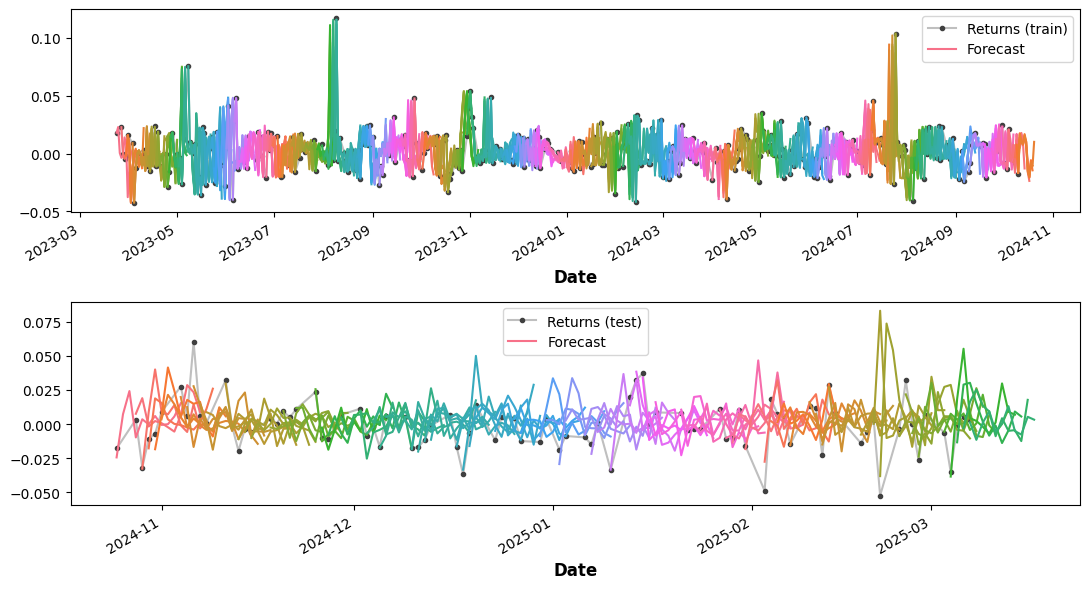

In [32]:
base_model  = XGBRegressor(
    objective ='reg:squarederror',
    tree_method='auto',
    seed = 42)

# Pack it into Regressor Chain to predict the next 10 days
modelchain = RegressorChain(estimator=base_model)

modelchain.fit(X_train, y_train)
y_hat_train = pd.DataFrame(modelchain.predict(X_train), index=y_train.index, columns=y_train.columns)
y_hat_test = pd.DataFrame(modelchain.predict(X_test), index=y_test.index, columns=y_test.columns)
evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

Train RMSE: 0.00314
Test RMSE: 0.01909


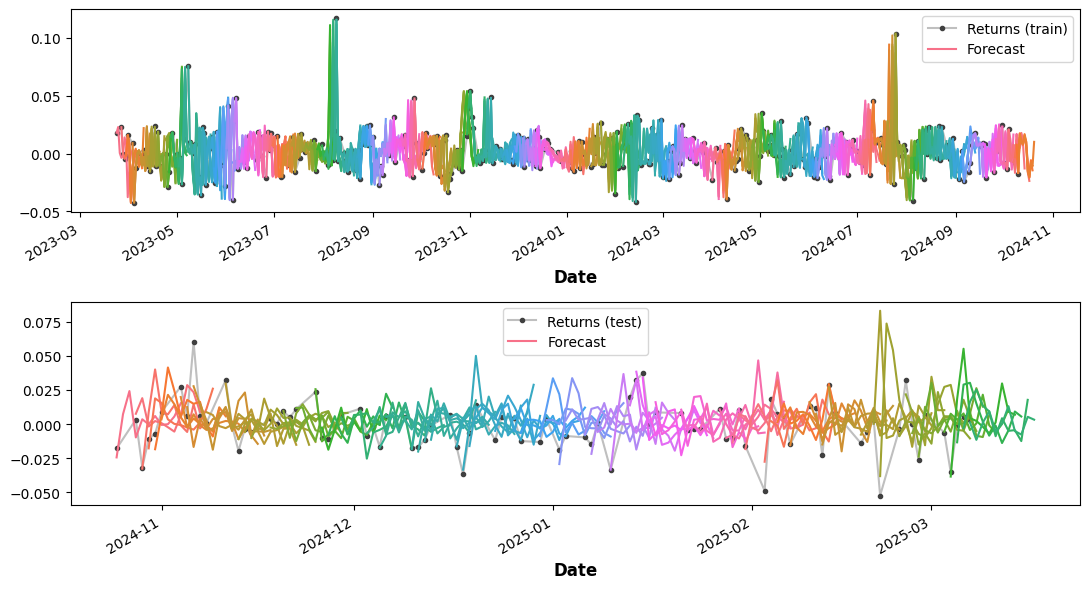

In [ ]:
base_model  = XGBRegressor(
    objective ='reg:squarederror',
    tree_method='auto',
    n_estimators=100,
    max_depth=6,
    seed = 42)

# Pack it into Regressor Chain to predict the next 10 days
modelchain = RegressorChain(estimator=base_model)

modelchain.fit(X_train, y_train)
y_hat_train = pd.DataFrame(modelchain.predict(X_train), index=y_train.index, columns=y_train.columns)
y_hat_test = pd.DataFrame(modelchain.predict(X_test), index=y_test.index, columns=y_test.columns)
evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

### Tuning the XGB Regressor

In [42]:
base_model  = XGBRegressor(
    objective ='reg:squarederror',
    tree_method='auto',
    seed = 42)

# Pack it into Regressor Chain to predict the next 10 days
modelchain = RegressorChain(estimator=base_model)

search_space = {
    'estimator__learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'estimator__max_depth': Integer(3, 10),
    'estimator__n_estimators': Integer(50, 1000),
    'estimator__subsample': Real(0.6, 1.0),
    'estimator__colsample_bytree': Real(0.6, 1.0),
    'estimator__reg_alpha': Real(0, 10),
    'estimator__reg_lambda': Real(0, 10)
}

bayes_search = BayesSearchCV(
    modelchain,
    search_space,
    n_iter=50,
    cv=4,
    random_state=42,
    verbose=2
)

bayes_search.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[CV] END estimator__colsample_bytree=0.7640415835413256, estimator__learning_rate=0.17233925413725915, estimator__max_depth=10, estimator__n_estimators=350, estimator__reg_alpha=6.701479482689346, estimator__reg_lambda=4.141186324855385, estimator__subsample=0.7403725339596576; total time=   2.1s
[CV] END estimator__colsample_bytree=0.7640415835413256, estimator__learning_rate=0.17233925413725915, estimator__max_depth=10, estimator__n_estimators=350, estimator__reg_alpha=6.701479482689346, estimator__reg_lambda=4.141186324855385, estimator__subsample=0.7403725339596576; total time=   2.3s
[CV] END estimator__colsample_bytree=0.7640415835413256, estimator__learning_rate=0.17233925413725915, estimator__max_depth=10, estimator__n_estimators=350, estimator__reg_alpha=6.701479482689346, estimator__reg_lambda=4.141186324855385, estimator__subsample=0.7403725339596576; total time=   1.1s
[CV] END estimator__colsample_bytree=0.7640415835413256, estimator__learning_rate=0.17233925413725915, est

,estimator,"RegressorChai...ee=None, ...))"
,search_spaces,"{'estimator__colsample_bytree': Real(low=0.6,...m='normalize'), 'estimator__learning_rate': Real(low=0.01...m='normalize'), 'estimator__max_depth': Integer(low=3...m='normalize'), 'estimator__n_estimators': Integer(low=5...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,None
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,4


Best parameters: OrderedDict([('estimator__colsample_bytree', 0.6), ('estimator__learning_rate', 0.01), ('estimator__max_depth', 10), ('estimator__n_estimators', 976), ('estimator__reg_alpha', 0.43850103069825064), ('estimator__reg_lambda', 10.0), ('estimator__subsample', 0.8407858372682588)])


Train RMSE: 0.01623
Test RMSE: 0.01717


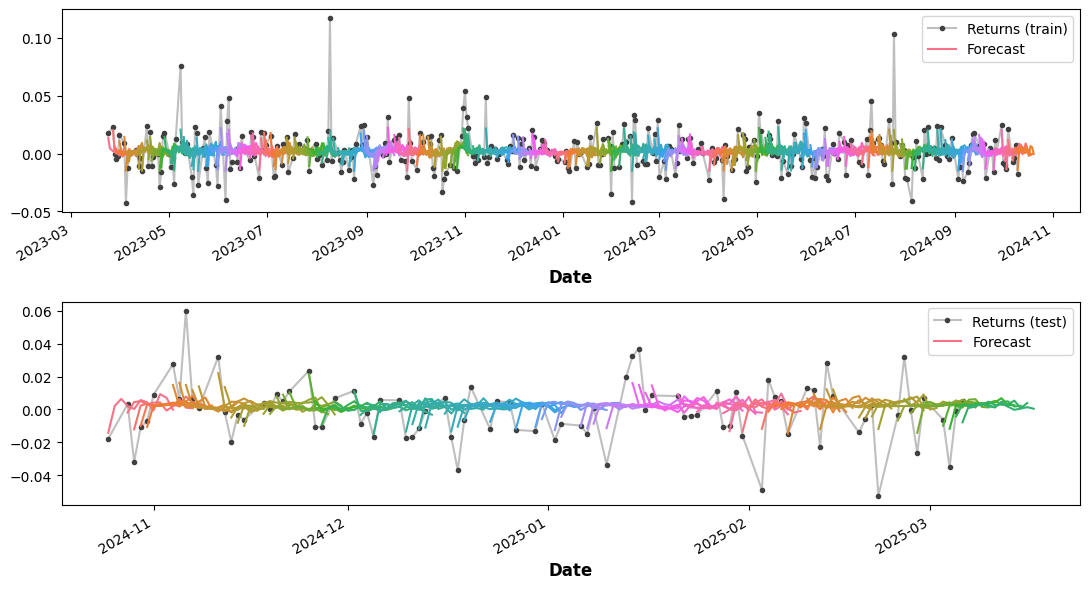

In [44]:
best_params = bayes_search.best_params_
print("Best parameters:", best_params)
best_estimator = bayes_search.best_estimator_

y_hat_train = pd.DataFrame(best_estimator.predict(X_train), index=y_train.index, columns=y_train.columns)
y_hat_test = pd.DataFrame(best_estimator.predict(X_test), index=y_test.index, columns=y_test.columns)
evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

## Training and forecasting for the test set

In [14]:
# Helper functions

def make_forecast(df, estimator):
    X_pred = df.iloc[[-1], :]
    X_pred = X_pred.drop(columns=[target])
    y_pred = estimator.predict(X_pred)
    y_pred = pd.DataFrame(y_pred, index=X_pred.index, columns=y_test.columns)
    return y_pred

def create_submission_file(forecasts, test_files, fnamesuffix=''):
    if LOCAL:
        fpath = os.path.join(rootpath, 'data', 'stock-price-prediction-challenge', 'sample_submission.csv')
    else:
        fpath = '/kaggle/input/stock-price-prediction-challenge/sample_submission.csv'
    sample_submission = pd.read_csv(fpath)
    # sample_submission
    dates_from_sample = sample_submission['Date']

    submission_df = pd.DataFrame(dates_from_sample, columns=['Date'])

    for test_file in test_files:
        predictions = forecasts[test_file].iloc[:, -10:].values.reshape(-1, 1)
        test_no = test_file.split('_')[1]
        col = f'Returns_{test_no}'
        submission_df[col] = predictions
    from datetime import datetime
    now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    fpath = f'Regression_submission{fnamesuffix}_{now}.csv'
    submission_df.to_csv(fpath, index=False)
    print(f'Submission file created: {fpath}')

In [47]:
# use the best paraters to initialize a new model
def initialize_XGBRegressor_with_best_params(best_params):
    xgb_params = {k.replace('estimator__', ''): v for k, v in best_params.items()}
    base_model = XGBRegressor(
        objective='reg:squarederror',
        tree_method='auto',
        seed=42,
        **xgb_params
    )
    # Pack it into Regressor Chain to predict the next 10 days
    modelchain = RegressorChain(estimator=base_model)
    return modelchain

In [48]:
forecasts = {}
train_rmse_list = []
test_rmse_list = []
test_files= ['test_1', 'test_2', 'test_3', 'test_4', 'test_5']
for test_file in test_files:
    print('Training and Forecasting for:', test_file)
    target = 'Returns'
    df = get_ticker_df(test_file)
    df = add_indice_features(df, target=target)
    df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)

    train_df, test_df = split_df(df, train_ratio=0.8)
    X_train, y_train = get_X_y_multistep(train_df, steps=11, target='Returns')
    X_test, y_test = get_X_y_multistep(test_df, steps=11, target='Returns')

    estimator = initialize_XGBRegressor_with_best_params(best_params)
    estimator.fit(X_train, y_train)

    y_hat_train = pd.DataFrame(estimator.predict(X_train), index=y_train.index, columns=y_train.columns)
    y_hat_test = pd.DataFrame(estimator.predict(X_test), index=y_test.index, columns=y_test.columns)
    train_rmse = root_mean_squared_error(y_train, y_hat_train)
    test_rmse = root_mean_squared_error(y_test, y_hat_test)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}\n"))
    forecast = make_forecast(df, estimator)
    forecasts[test_file] = forecast

avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
print(f'Average Train RMSE: {avg_train_rmse:.5f}, Average Test RMSE: {avg_test_rmse:.5f}')


Training and Forecasting for: test_1
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.02323
Test RMSE: 0.02306

Training and Forecasting for: test_2
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01160
Test RMSE: 0.01343

Training and Forecasting for: test_3
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01398
Test RMSE: 0.01899

Training and Forecasting for: test_4
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.02762
Test RMSE: 0.02703

Training and Forecasting for: test_5
sha

In [49]:
create_submission_file(forecasts, test_files, fnamesuffix='_XGBRegChain')

Submission file created: Regression_submission_XGBRegChain_2025-07-16_15-51-04.csv
